# Прогнозирование среднемесячной зарплаты в РФ

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России.

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Review criterialess 

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для p,q,P,Q
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q.
7. Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('./WAG_C_M.csv', delimiter=';', index_col='month', parse_dates=['month'], dayfirst=True,)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


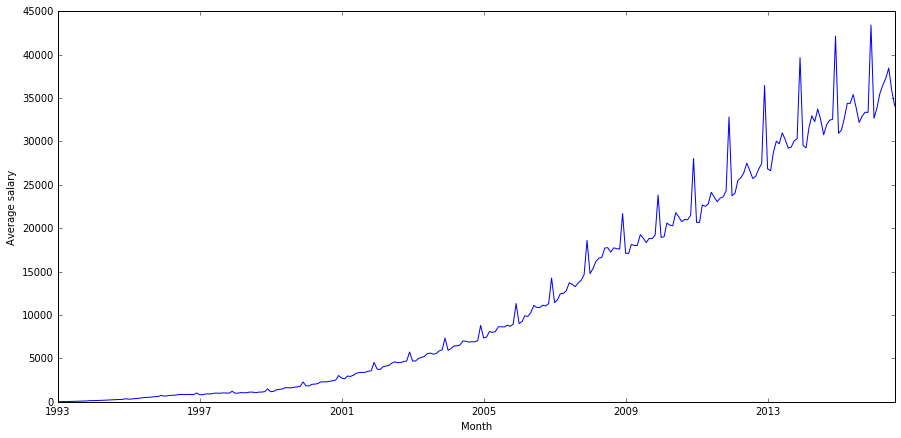

In [3]:
plt.figure(figsize(15,7))
plt.plot(data.WAG_C_M)
plt.ylabel('Average salary')
plt.xlabel('Month')

На графике мы видим некоторый тренд и сезонность. Дисперсия со временем растет.
Первым делом стабилизируем дисперсию.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


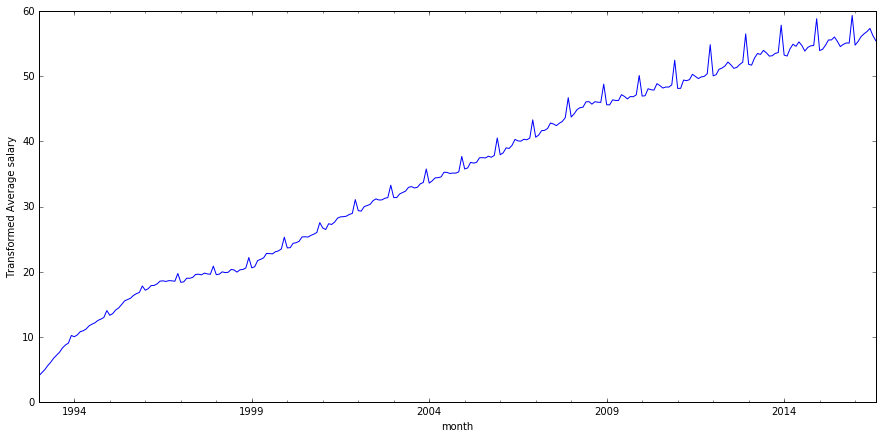

In [4]:
data['wag_c_m_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wag_c_m_box.plot()
plt.ylabel('Transformed Average salary')

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_c_m_box)[1])

Критерий Дики-Фуллера подтверждает гипотезу нестационарности, да и визуально в данных виден тренд.

Обычное дифференцирование

Критерий Дики-Фуллера: p=0.014396


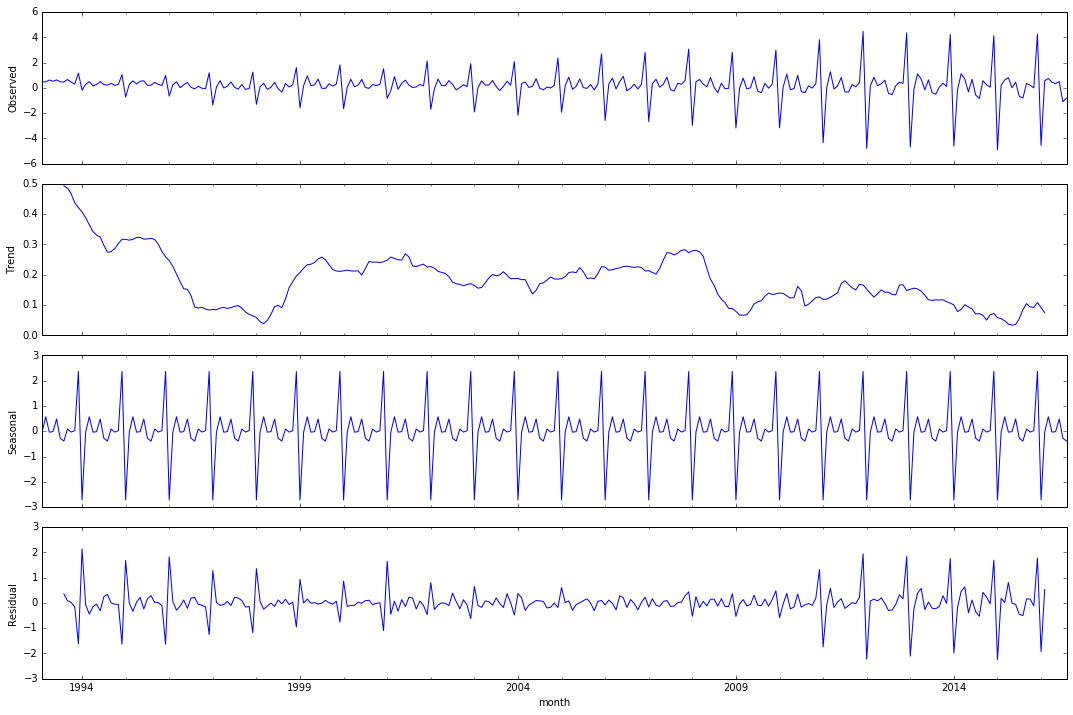

In [6]:
data['wag_c_m_diff'] = data.wag_c_m_box - data.wag_c_m_box.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_c_m_diff[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_c_m_diff[1:])[1])

Обычное дифференцирование не помогло, критерий больше 0.05. 
Добавляем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.000000


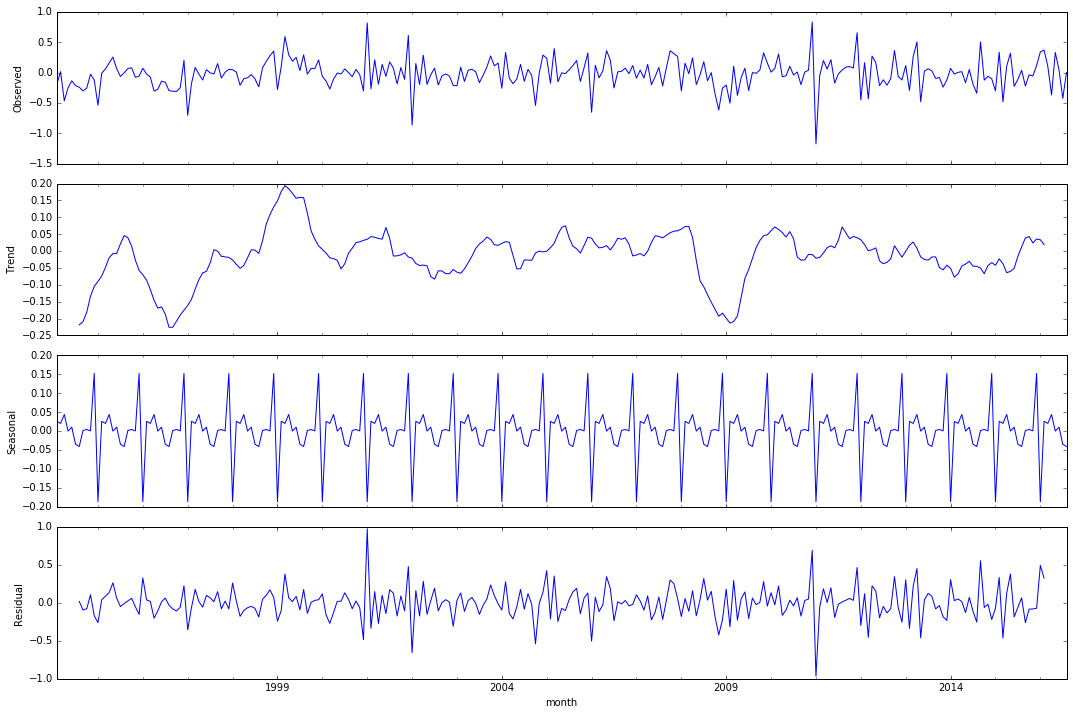

In [7]:
s = 12 # длина сезона 12 месяцев
data['wag_c_m_diff2'] = data.wag_c_m_diff - data.wag_c_m_diff.shift(s)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_c_m_diff2[s+1:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_c_m_diff2[s+1:])[1])

# Подбор модели

Далее строим кореллограммы для подбора параметров моделей.

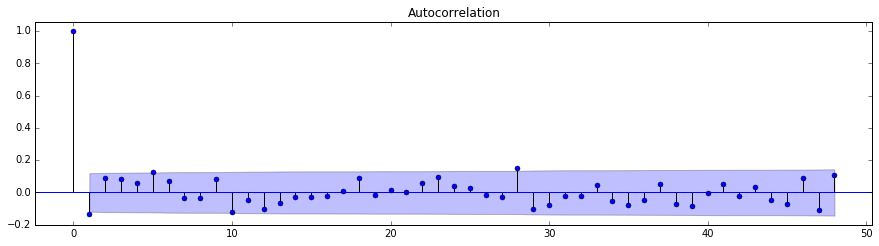

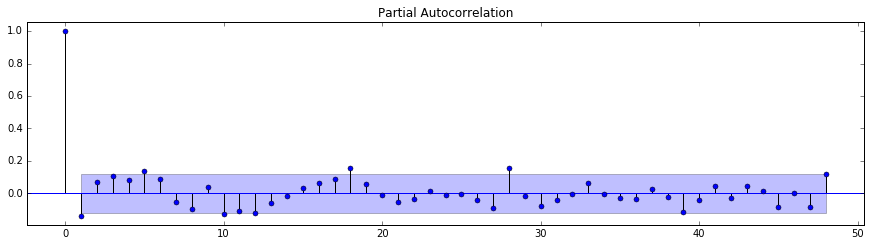

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_c_m_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_c_m_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальное приближение Q=0, q=5, P=1, p=5

In [9]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [10]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_c_m_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
CPU times: user 54.8 s, sys: 810 ms, total: 55.6 s
Wall time: 58.1 s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
52,"(5, 5, 1, 0)",-25.998188
51,"(5, 5, 0, 0)",-22.675258
20,"(1, 5, 1, 0)",-15.867144
37,"(3, 5, 0, 0)",-15.199464
38,"(3, 5, 1, 0)",-14.797997


In [13]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        wag_c_m_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.999
Date:                            Wed, 12 Apr 2017   AIC                            -25.998
Time:                                    00:13:43   BIC                             17.790
Sample:                                01-01-1993   HQIC                            -8.443
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0383     10.718      0.004      0.997     -20.969      21.045
ar.L2          0.0113      7.337      0.002      0.999     -14.369      14.391
ar.L3          0.5595      4.573      0.122      0.903      -8.404       9.523
ar.L4         -0.1034      8.935     -0.012      0.991     -17.616      17.409
ar.L5         -0.4077      6.883     -0.059      0.953     -13.897      13.082
ma.L1         -0.2573     10.873     -0.024      0.981     -21.568      21.053
ma.L2          0.0931      9.508      0.010      0.992     -18.542      18.728
ma.L3         -0.5186      7.124     -0.073      0.942     -14.482      13.445
ma.L4          0.3153     10.193      0.031      0.975     -19.663      20.294
ma.L5          0.6005     10.278      0.058      0.953     -19.544      20.745
ar.S.L12      -0.1498      0.060     -2.500      0.012      -0.267      -0.032
sigma2         0.0475      0.093      0.513      0.608      -0.134       0.229
===================================================================================
Ljung-Box (Q):                       25.28   Jarque-Bera (JB):                53.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотрим на остатки лучшей модели.

Они похожи на белый шум без какого-то смещения. То что нам и нужно. Критерии Дики-Фуллера и Стьюдента тем более подтверждают этот факт.

Критерий Стьюдента: p=0.175581
Критерий Дики-Фуллера: p=0.000000


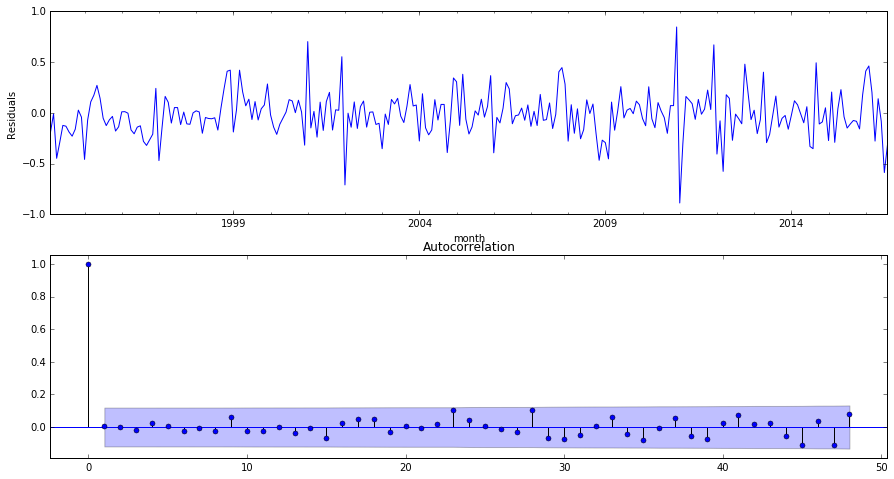

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [15]:
# функцию обратного преобразования Бокса-Кокса:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Сравним полученную модель с настоящими данными.

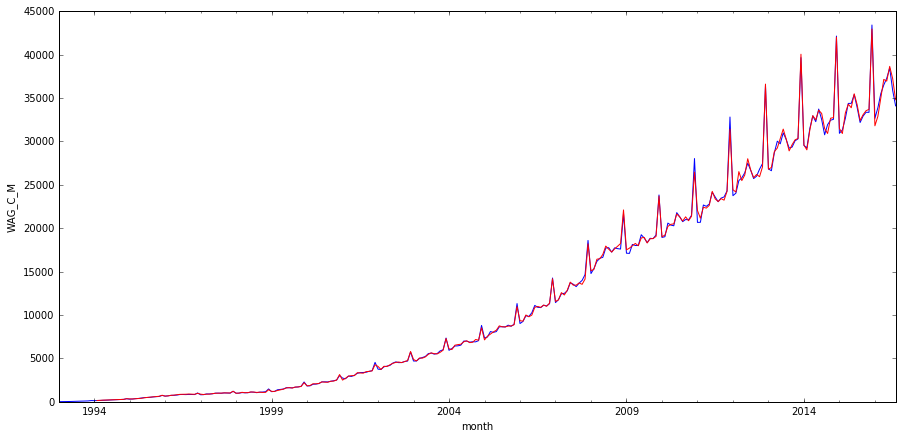

In [16]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

# Прогноз

Построим прогноз на 36 месяцев вперед.

In [17]:
print(data.shape)

(284, 5)


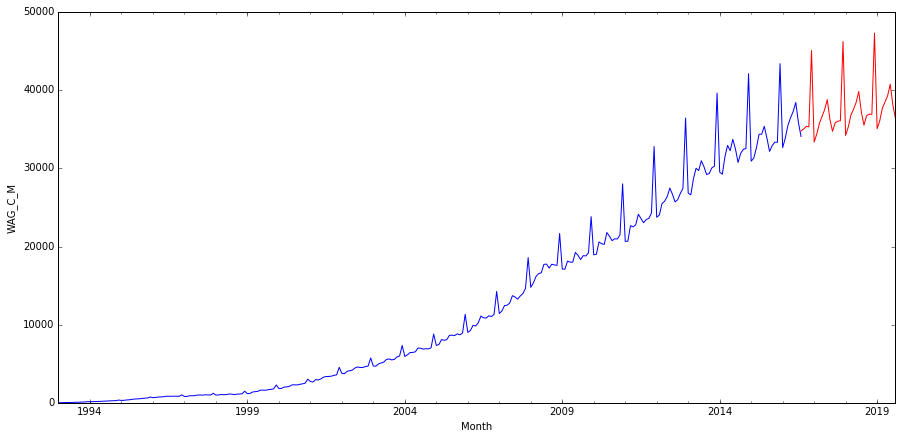

In [18]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=283, end=283+36), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
plt.xlabel('Month')
pylab.show()